# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [0]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [0]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [0]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

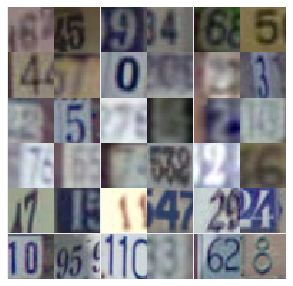

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [0]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [0]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [0]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, units=4*4*512)
        x1 = tf.reshape(x1, shape=(-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha*x1, x1)
        
        ## Second layer. Input shape (4,4,512)
        x2 = tf.layers.conv2d_transpose(x1, filters=256,kernel_size=5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha*x2, x2)
        
        ## Third layer. Input shape (8,8,256)
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha*x3, x3)
        
        # Output layer, Input shape:(16,16,128), output shape: (32,32,3)
        logits = tf.layers.conv2d_transpose(x3, filters=output_dim, kernel_size=5, strides=2, padding="same")
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [0]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)
        
        # Second layer, input size(16,16,64)
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        # Third layer, input size(8,8,128)
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        # Final output, input size(4,4,256)
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, units=1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [0]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [0]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [0]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [0]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=7000, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [0]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 16
epochs = 3
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/3... Discriminator Loss: 2.6840... Generator Loss: 0.1376
Epoch 1/3... Discriminator Loss: 0.6260... Generator Loss: 0.9345
Epoch 1/3... Discriminator Loss: 0.8839... Generator Loss: 0.7141
Epoch 1/3... Discriminator Loss: 0.2001... Generator Loss: 1.8731
Epoch 1/3... Discriminator Loss: 0.1427... Generator Loss: 2.3846
Epoch 1/3... Discriminator Loss: 0.1599... Generator Loss: 2.3473
Epoch 1/3... Discriminator Loss: 0.0846... Generator Loss: 3.9509
Epoch 1/3... Discriminator Loss: 0.0851... Generator Loss: 2.9295
Epoch 1/3... Discriminator Loss: 0.2364... Generator Loss: 1.8938
Epoch 1/3... Discriminator Loss: 0.1848... Generator Loss: 2.1861
Epoch 1/3... Discriminator Loss: 0.1846... Generator Loss: 17.0915
Epoch 1/3... Discriminator Loss: 0.1947... Generator Loss: 2.4402
Epoch 1/3... Discriminator Loss: 0.1598... Generator Loss: 2.7751
Epoch 1/3... Discriminator Loss: 0.2536... Generator Loss: 3.0528
Epoch 1/3... Discriminator Loss: 0.5216... Generator Loss: 2.2432
Epoch 1/3

Epoch 1/3... Discriminator Loss: 0.2970... Generator Loss: 3.3601
Epoch 1/3... Discriminator Loss: 1.3187... Generator Loss: 1.6015
Epoch 1/3... Discriminator Loss: 1.1833... Generator Loss: 0.5652
Epoch 1/3... Discriminator Loss: 0.6741... Generator Loss: 1.3265
Epoch 1/3... Discriminator Loss: 0.5783... Generator Loss: 2.3471
Epoch 1/3... Discriminator Loss: 0.5438... Generator Loss: 1.2070
Epoch 1/3... Discriminator Loss: 0.5143... Generator Loss: 1.6325
Epoch 1/3... Discriminator Loss: 1.5228... Generator Loss: 0.3755
Epoch 1/3... Discriminator Loss: 0.4160... Generator Loss: 2.0831
Epoch 1/3... Discriminator Loss: 0.3839... Generator Loss: 1.6694
Epoch 1/3... Discriminator Loss: 1.4189... Generator Loss: 0.9898
Epoch 1/3... Discriminator Loss: 2.1848... Generator Loss: 0.5006
Epoch 1/3... Discriminator Loss: 0.6777... Generator Loss: 1.0880
Epoch 1/3... Discriminator Loss: 0.7214... Generator Loss: 1.1503
Epoch 1/3... Discriminator Loss: 0.9235... Generator Loss: 0.7738
Epoch 1/3.

Epoch 1/3... Discriminator Loss: 0.8181... Generator Loss: 0.9975
Epoch 1/3... Discriminator Loss: 1.0237... Generator Loss: 0.8107
Epoch 1/3... Discriminator Loss: 0.8988... Generator Loss: 1.0962
Epoch 1/3... Discriminator Loss: 1.0925... Generator Loss: 1.0513
Epoch 1/3... Discriminator Loss: 1.0645... Generator Loss: 0.9035
Epoch 1/3... Discriminator Loss: 1.1754... Generator Loss: 0.7650
Epoch 1/3... Discriminator Loss: 0.5946... Generator Loss: 1.5008
Epoch 1/3... Discriminator Loss: 1.0169... Generator Loss: 0.8654
Epoch 1/3... Discriminator Loss: 0.6226... Generator Loss: 1.1132
Epoch 1/3... Discriminator Loss: 1.1817... Generator Loss: 0.8177
Epoch 1/3... Discriminator Loss: 0.5663... Generator Loss: 1.0166
Epoch 1/3... Discriminator Loss: 0.9653... Generator Loss: 0.7898
Epoch 1/3... Discriminator Loss: 1.0448... Generator Loss: 0.9949
Epoch 1/3... Discriminator Loss: 0.7756... Generator Loss: 0.7302
Epoch 1/3... Discriminator Loss: 0.7163... Generator Loss: 1.3372
Epoch 1/3.

Epoch 1/3... Discriminator Loss: 0.8390... Generator Loss: 1.1214
Epoch 1/3... Discriminator Loss: 0.8126... Generator Loss: 0.9790
Epoch 1/3... Discriminator Loss: 0.6633... Generator Loss: 1.0424
Epoch 1/3... Discriminator Loss: 1.5835... Generator Loss: 0.4585
Epoch 1/3... Discriminator Loss: 1.2097... Generator Loss: 0.6718
Epoch 1/3... Discriminator Loss: 0.8365... Generator Loss: 0.9499
Epoch 1/3... Discriminator Loss: 1.0410... Generator Loss: 0.9772
Epoch 1/3... Discriminator Loss: 1.1591... Generator Loss: 0.7041
Epoch 1/3... Discriminator Loss: 0.9400... Generator Loss: 0.9120
Epoch 1/3... Discriminator Loss: 0.9114... Generator Loss: 0.8643
Epoch 1/3... Discriminator Loss: 1.3848... Generator Loss: 0.5711
Epoch 1/3... Discriminator Loss: 1.0478... Generator Loss: 0.8050
Epoch 1/3... Discriminator Loss: 0.8444... Generator Loss: 1.0364
Epoch 1/3... Discriminator Loss: 0.5868... Generator Loss: 1.0536
Epoch 1/3... Discriminator Loss: 1.4095... Generator Loss: 0.6140
Epoch 1/3.

Epoch 1/3... Discriminator Loss: 0.6613... Generator Loss: 1.1928
Epoch 1/3... Discriminator Loss: 1.1578... Generator Loss: 0.8153
Epoch 1/3... Discriminator Loss: 1.5829... Generator Loss: 0.4592
Epoch 1/3... Discriminator Loss: 1.1621... Generator Loss: 0.7658
Epoch 1/3... Discriminator Loss: 1.0698... Generator Loss: 0.8517
Epoch 1/3... Discriminator Loss: 0.7905... Generator Loss: 0.8657
Epoch 1/3... Discriminator Loss: 1.0972... Generator Loss: 0.7992
Epoch 1/3... Discriminator Loss: 0.9828... Generator Loss: 0.5871
Epoch 1/3... Discriminator Loss: 0.5205... Generator Loss: 1.1940
Epoch 1/3... Discriminator Loss: 0.8021... Generator Loss: 1.0725
Epoch 1/3... Discriminator Loss: 1.1563... Generator Loss: 0.8594
Epoch 1/3... Discriminator Loss: 0.8750... Generator Loss: 1.1387
Epoch 1/3... Discriminator Loss: 0.8454... Generator Loss: 0.9458
Epoch 1/3... Discriminator Loss: 0.6918... Generator Loss: 1.5187
Epoch 1/3... Discriminator Loss: 0.8175... Generator Loss: 1.2506
Epoch 1/3.

Epoch 1/3... Discriminator Loss: 1.0911... Generator Loss: 1.0913
Epoch 1/3... Discriminator Loss: 0.7511... Generator Loss: 1.1074
Epoch 1/3... Discriminator Loss: 1.0413... Generator Loss: 0.8055
Epoch 1/3... Discriminator Loss: 0.4279... Generator Loss: 1.2855
Epoch 1/3... Discriminator Loss: 1.6796... Generator Loss: 0.4109
Epoch 1/3... Discriminator Loss: 1.1227... Generator Loss: 0.7564
Epoch 1/3... Discriminator Loss: 1.1792... Generator Loss: 0.7002
Epoch 1/3... Discriminator Loss: 0.6453... Generator Loss: 1.1743
Epoch 1/3... Discriminator Loss: 0.8698... Generator Loss: 0.9655
Epoch 1/3... Discriminator Loss: 0.7617... Generator Loss: 0.9291
Epoch 1/3... Discriminator Loss: 0.7389... Generator Loss: 0.9442
Epoch 1/3... Discriminator Loss: 0.7411... Generator Loss: 1.0436
Epoch 1/3... Discriminator Loss: 1.0769... Generator Loss: 0.8845
Epoch 1/3... Discriminator Loss: 1.2515... Generator Loss: 0.6221
Epoch 1/3... Discriminator Loss: 1.3705... Generator Loss: 0.4738
Epoch 1/3.

Epoch 1/3... Discriminator Loss: 0.2524... Generator Loss: 1.6338
Epoch 1/3... Discriminator Loss: 0.8075... Generator Loss: 1.2054
Epoch 1/3... Discriminator Loss: 1.0511... Generator Loss: 0.7079
Epoch 1/3... Discriminator Loss: 0.6101... Generator Loss: 1.0621
Epoch 1/3... Discriminator Loss: 0.6010... Generator Loss: 1.1413
Epoch 1/3... Discriminator Loss: 0.9091... Generator Loss: 0.9813
Epoch 1/3... Discriminator Loss: 1.2451... Generator Loss: 0.6108
Epoch 1/3... Discriminator Loss: 0.6445... Generator Loss: 1.2810
Epoch 1/3... Discriminator Loss: 0.5377... Generator Loss: 1.0244
Epoch 1/3... Discriminator Loss: 1.0261... Generator Loss: 0.8205
Epoch 1/3... Discriminator Loss: 0.8915... Generator Loss: 0.9509
Epoch 1/3... Discriminator Loss: 2.0122... Generator Loss: 0.7256
Epoch 1/3... Discriminator Loss: 1.7790... Generator Loss: 0.5160
Epoch 1/3... Discriminator Loss: 0.2061... Generator Loss: 2.4440
Epoch 1/3... Discriminator Loss: 1.0616... Generator Loss: 0.9869
Epoch 1/3.

Epoch 1/3... Discriminator Loss: 1.0350... Generator Loss: 1.0947
Epoch 1/3... Discriminator Loss: 0.4709... Generator Loss: 1.3189
Epoch 1/3... Discriminator Loss: 1.0874... Generator Loss: 0.7723
Epoch 1/3... Discriminator Loss: 0.9564... Generator Loss: 0.9977
Epoch 1/3... Discriminator Loss: 0.8042... Generator Loss: 1.2012
Epoch 1/3... Discriminator Loss: 1.0348... Generator Loss: 0.9002
Epoch 1/3... Discriminator Loss: 1.2051... Generator Loss: 0.5625
Epoch 1/3... Discriminator Loss: 0.7346... Generator Loss: 0.9001
Epoch 1/3... Discriminator Loss: 0.7533... Generator Loss: 1.2251
Epoch 1/3... Discriminator Loss: 0.6446... Generator Loss: 1.4381
Epoch 1/3... Discriminator Loss: 0.9127... Generator Loss: 0.8877
Epoch 1/3... Discriminator Loss: 1.5730... Generator Loss: 0.6114
Epoch 1/3... Discriminator Loss: 0.9273... Generator Loss: 1.1263
Epoch 1/3... Discriminator Loss: 0.7367... Generator Loss: 1.1304
Epoch 1/3... Discriminator Loss: 0.9524... Generator Loss: 0.9558
Epoch 1/3.

Epoch 1/3... Discriminator Loss: 1.0275... Generator Loss: 1.0662
Epoch 1/3... Discriminator Loss: 0.6675... Generator Loss: 1.1074
Epoch 1/3... Discriminator Loss: 0.7900... Generator Loss: 1.5584
Epoch 1/3... Discriminator Loss: 0.9381... Generator Loss: 0.9290
Epoch 1/3... Discriminator Loss: 0.5436... Generator Loss: 1.1280
Epoch 1/3... Discriminator Loss: 1.2018... Generator Loss: 0.6130
Epoch 1/3... Discriminator Loss: 0.6077... Generator Loss: 1.5342
Epoch 1/3... Discriminator Loss: 1.1275... Generator Loss: 1.0892
Epoch 1/3... Discriminator Loss: 0.6830... Generator Loss: 1.1971
Epoch 1/3... Discriminator Loss: 1.4261... Generator Loss: 0.5303
Epoch 1/3... Discriminator Loss: 1.3467... Generator Loss: 0.5754
Epoch 1/3... Discriminator Loss: 0.7587... Generator Loss: 1.0100
Epoch 1/3... Discriminator Loss: 0.8851... Generator Loss: 0.8959
Epoch 1/3... Discriminator Loss: 0.7717... Generator Loss: 0.9746
Epoch 1/3... Discriminator Loss: 0.9145... Generator Loss: 0.9446
Epoch 1/3.

Epoch 2/3... Discriminator Loss: 1.1849... Generator Loss: 0.7226
Epoch 2/3... Discriminator Loss: 1.6988... Generator Loss: 1.2410
Epoch 2/3... Discriminator Loss: 1.1219... Generator Loss: 0.6483
Epoch 2/3... Discriminator Loss: 1.5308... Generator Loss: 0.6060
Epoch 2/3... Discriminator Loss: 1.0994... Generator Loss: 0.6126
Epoch 2/3... Discriminator Loss: 0.6672... Generator Loss: 1.0526
Epoch 2/3... Discriminator Loss: 0.3222... Generator Loss: 1.7860
Epoch 2/3... Discriminator Loss: 1.0510... Generator Loss: 0.8487
Epoch 2/3... Discriminator Loss: 0.3378... Generator Loss: 1.5525
Epoch 2/3... Discriminator Loss: 0.4208... Generator Loss: 1.2263
Epoch 2/3... Discriminator Loss: 0.8611... Generator Loss: 0.8623
Epoch 2/3... Discriminator Loss: 0.5701... Generator Loss: 1.8554
Epoch 2/3... Discriminator Loss: 1.3689... Generator Loss: 0.6492
Epoch 2/3... Discriminator Loss: 0.7540... Generator Loss: 0.8450
Epoch 2/3... Discriminator Loss: 0.5657... Generator Loss: 1.5487
Epoch 2/3.

Epoch 2/3... Discriminator Loss: 0.8460... Generator Loss: 1.2065
Epoch 2/3... Discriminator Loss: 1.1382... Generator Loss: 0.5284
Epoch 2/3... Discriminator Loss: 0.2250... Generator Loss: 1.8362
Epoch 2/3... Discriminator Loss: 0.5106... Generator Loss: 1.1474
Epoch 2/3... Discriminator Loss: 1.0714... Generator Loss: 0.5974
Epoch 2/3... Discriminator Loss: 0.6255... Generator Loss: 1.0979
Epoch 2/3... Discriminator Loss: 0.3931... Generator Loss: 1.4972
Epoch 2/3... Discriminator Loss: 0.9068... Generator Loss: 0.8677
Epoch 2/3... Discriminator Loss: 0.8216... Generator Loss: 0.8215
Epoch 2/3... Discriminator Loss: 0.8231... Generator Loss: 0.9472
Epoch 2/3... Discriminator Loss: 0.5669... Generator Loss: 1.0246
Epoch 2/3... Discriminator Loss: 0.5498... Generator Loss: 1.1230
Epoch 2/3... Discriminator Loss: 1.3182... Generator Loss: 0.5114
Epoch 2/3... Discriminator Loss: 0.5649... Generator Loss: 1.0185
Epoch 2/3... Discriminator Loss: 0.9777... Generator Loss: 0.6905
Epoch 2/3.

Epoch 2/3... Discriminator Loss: 0.4347... Generator Loss: 1.3408
Epoch 2/3... Discriminator Loss: 1.0347... Generator Loss: 0.6219
Epoch 2/3... Discriminator Loss: 0.6983... Generator Loss: 0.9864
Epoch 2/3... Discriminator Loss: 0.5665... Generator Loss: 1.0785
Epoch 2/3... Discriminator Loss: 0.6039... Generator Loss: 1.4816
Epoch 2/3... Discriminator Loss: 0.8535... Generator Loss: 0.8342
Epoch 2/3... Discriminator Loss: 1.3056... Generator Loss: 0.4715
Epoch 2/3... Discriminator Loss: 0.9124... Generator Loss: 0.8251
Epoch 2/3... Discriminator Loss: 1.2582... Generator Loss: 0.8616
Epoch 2/3... Discriminator Loss: 0.2877... Generator Loss: 1.5624
Epoch 2/3... Discriminator Loss: 0.8709... Generator Loss: 0.8695
Epoch 2/3... Discriminator Loss: 0.6240... Generator Loss: 1.2869
Epoch 2/3... Discriminator Loss: 1.1404... Generator Loss: 0.7214
Epoch 2/3... Discriminator Loss: 0.5447... Generator Loss: 1.0446
Epoch 2/3... Discriminator Loss: 0.4261... Generator Loss: 1.3058
Epoch 2/3.

Epoch 2/3... Discriminator Loss: 0.5691... Generator Loss: 0.9331
Epoch 2/3... Discriminator Loss: 1.1185... Generator Loss: 0.6520
Epoch 2/3... Discriminator Loss: 1.0201... Generator Loss: 0.9526
Epoch 2/3... Discriminator Loss: 1.4163... Generator Loss: 0.4643
Epoch 2/3... Discriminator Loss: 0.8367... Generator Loss: 0.8933
Epoch 2/3... Discriminator Loss: 0.7853... Generator Loss: 0.7938
Epoch 2/3... Discriminator Loss: 0.6974... Generator Loss: 1.0563
Epoch 2/3... Discriminator Loss: 0.9645... Generator Loss: 0.8202
Epoch 2/3... Discriminator Loss: 0.2811... Generator Loss: 1.6284
Epoch 2/3... Discriminator Loss: 1.1082... Generator Loss: 0.5209
Epoch 2/3... Discriminator Loss: 1.2823... Generator Loss: 0.4768
Epoch 2/3... Discriminator Loss: 1.0305... Generator Loss: 0.8911
Epoch 2/3... Discriminator Loss: 0.6561... Generator Loss: 1.1285
Epoch 2/3... Discriminator Loss: 0.5851... Generator Loss: 1.2074
Epoch 2/3... Discriminator Loss: 1.0659... Generator Loss: 0.5657
Epoch 2/3.

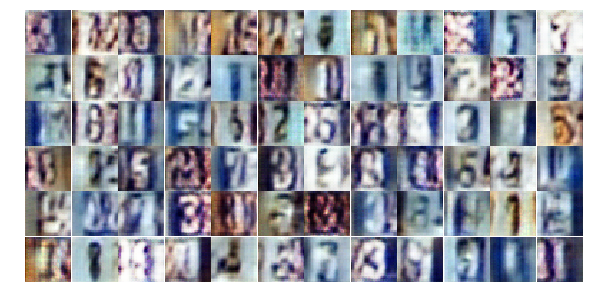

Epoch 2/3... Discriminator Loss: 1.0857... Generator Loss: 1.1109
Epoch 2/3... Discriminator Loss: 0.9054... Generator Loss: 0.8223
Epoch 2/3... Discriminator Loss: 0.8392... Generator Loss: 1.0520
Epoch 2/3... Discriminator Loss: 1.7488... Generator Loss: 0.3824
Epoch 2/3... Discriminator Loss: 0.8720... Generator Loss: 0.5893
Epoch 2/3... Discriminator Loss: 1.2909... Generator Loss: 0.4099
Epoch 2/3... Discriminator Loss: 0.5091... Generator Loss: 1.0041
Epoch 2/3... Discriminator Loss: 0.4491... Generator Loss: 1.1743
Epoch 2/3... Discriminator Loss: 1.0034... Generator Loss: 0.9170
Epoch 2/3... Discriminator Loss: 0.8573... Generator Loss: 0.8343
Epoch 2/3... Discriminator Loss: 1.0254... Generator Loss: 0.8796
Epoch 2/3... Discriminator Loss: 0.6408... Generator Loss: 1.0955
Epoch 2/3... Discriminator Loss: 0.6024... Generator Loss: 1.0386
Epoch 2/3... Discriminator Loss: 1.0697... Generator Loss: 0.6553
Epoch 2/3... Discriminator Loss: 0.9076... Generator Loss: 0.9922
Epoch 2/3.

Epoch 2/3... Discriminator Loss: 0.2418... Generator Loss: 1.8378
Epoch 2/3... Discriminator Loss: 0.5497... Generator Loss: 1.0701
Epoch 2/3... Discriminator Loss: 1.7075... Generator Loss: 0.3298
Epoch 2/3... Discriminator Loss: 1.3658... Generator Loss: 0.6130
Epoch 2/3... Discriminator Loss: 0.6305... Generator Loss: 1.1592
Epoch 2/3... Discriminator Loss: 1.1892... Generator Loss: 0.6882
Epoch 2/3... Discriminator Loss: 0.5052... Generator Loss: 1.4700
Epoch 2/3... Discriminator Loss: 0.3366... Generator Loss: 1.6257
Epoch 2/3... Discriminator Loss: 1.1506... Generator Loss: 0.5583
Epoch 2/3... Discriminator Loss: 1.2177... Generator Loss: 0.5965
Epoch 2/3... Discriminator Loss: 0.4942... Generator Loss: 1.0765
Epoch 2/3... Discriminator Loss: 0.5524... Generator Loss: 1.3075
Epoch 2/3... Discriminator Loss: 1.5202... Generator Loss: 0.4816
Epoch 2/3... Discriminator Loss: 1.0177... Generator Loss: 1.0314
Epoch 2/3... Discriminator Loss: 0.9396... Generator Loss: 0.6700
Epoch 2/3.

Epoch 2/3... Discriminator Loss: 0.6901... Generator Loss: 0.9468
Epoch 2/3... Discriminator Loss: 0.5264... Generator Loss: 1.4344
Epoch 2/3... Discriminator Loss: 1.4094... Generator Loss: 0.5494
Epoch 2/3... Discriminator Loss: 0.6967... Generator Loss: 0.9096
Epoch 2/3... Discriminator Loss: 0.8475... Generator Loss: 1.0480
Epoch 2/3... Discriminator Loss: 0.4326... Generator Loss: 1.4952
Epoch 2/3... Discriminator Loss: 0.9007... Generator Loss: 0.7591
Epoch 2/3... Discriminator Loss: 0.5723... Generator Loss: 1.2669
Epoch 2/3... Discriminator Loss: 0.7738... Generator Loss: 1.0714
Epoch 2/3... Discriminator Loss: 0.6575... Generator Loss: 1.0943
Epoch 2/3... Discriminator Loss: 1.0361... Generator Loss: 0.7100
Epoch 2/3... Discriminator Loss: 0.5900... Generator Loss: 1.4269
Epoch 2/3... Discriminator Loss: 0.6492... Generator Loss: 1.1618
Epoch 2/3... Discriminator Loss: 1.1136... Generator Loss: 0.7028
Epoch 2/3... Discriminator Loss: 0.5041... Generator Loss: 1.0208
Epoch 2/3.

Epoch 2/3... Discriminator Loss: 1.1029... Generator Loss: 0.5461
Epoch 2/3... Discriminator Loss: 0.7289... Generator Loss: 1.2785
Epoch 2/3... Discriminator Loss: 1.2762... Generator Loss: 0.6166
Epoch 2/3... Discriminator Loss: 1.0383... Generator Loss: 1.0003
Epoch 2/3... Discriminator Loss: 1.2113... Generator Loss: 0.5491
Epoch 2/3... Discriminator Loss: 0.6559... Generator Loss: 0.9639
Epoch 2/3... Discriminator Loss: 0.7069... Generator Loss: 1.0276
Epoch 2/3... Discriminator Loss: 1.1901... Generator Loss: 0.7190
Epoch 2/3... Discriminator Loss: 0.8365... Generator Loss: 1.4106
Epoch 2/3... Discriminator Loss: 0.9357... Generator Loss: 0.8416
Epoch 2/3... Discriminator Loss: 0.5725... Generator Loss: 1.1617
Epoch 2/3... Discriminator Loss: 0.6689... Generator Loss: 0.8992
Epoch 2/3... Discriminator Loss: 0.3875... Generator Loss: 1.3358
Epoch 2/3... Discriminator Loss: 0.8149... Generator Loss: 0.7823
Epoch 2/3... Discriminator Loss: 0.7539... Generator Loss: 1.1788
Epoch 2/3.

Epoch 3/3... Discriminator Loss: 0.4458... Generator Loss: 1.2880
Epoch 3/3... Discriminator Loss: 0.5613... Generator Loss: 1.0648
Epoch 3/3... Discriminator Loss: 0.7248... Generator Loss: 0.7572
Epoch 3/3... Discriminator Loss: 0.9888... Generator Loss: 0.8683
Epoch 3/3... Discriminator Loss: 0.5363... Generator Loss: 1.0068
Epoch 3/3... Discriminator Loss: 0.4370... Generator Loss: 1.2704
Epoch 3/3... Discriminator Loss: 1.0761... Generator Loss: 0.7165
Epoch 3/3... Discriminator Loss: 1.0261... Generator Loss: 0.9450
Epoch 3/3... Discriminator Loss: 1.2715... Generator Loss: 0.5855
Epoch 3/3... Discriminator Loss: 0.4766... Generator Loss: 1.2669
Epoch 3/3... Discriminator Loss: 0.8737... Generator Loss: 0.8818
Epoch 3/3... Discriminator Loss: 0.7948... Generator Loss: 0.7536
Epoch 3/3... Discriminator Loss: 0.6433... Generator Loss: 1.0556
Epoch 3/3... Discriminator Loss: 0.7066... Generator Loss: 0.9087
Epoch 3/3... Discriminator Loss: 0.4650... Generator Loss: 1.3039
Epoch 3/3.

Epoch 3/3... Discriminator Loss: 1.5512... Generator Loss: 0.5826
Epoch 3/3... Discriminator Loss: 1.3402... Generator Loss: 0.5797
Epoch 3/3... Discriminator Loss: 1.2515... Generator Loss: 0.6006
Epoch 3/3... Discriminator Loss: 0.7816... Generator Loss: 0.8747
Epoch 3/3... Discriminator Loss: 0.9794... Generator Loss: 0.8044
Epoch 3/3... Discriminator Loss: 0.9474... Generator Loss: 0.6857
Epoch 3/3... Discriminator Loss: 0.2912... Generator Loss: 1.5801
Epoch 3/3... Discriminator Loss: 1.1797... Generator Loss: 0.7680
Epoch 3/3... Discriminator Loss: 1.4193... Generator Loss: 0.4026
Epoch 3/3... Discriminator Loss: 1.1947... Generator Loss: 0.6020
Epoch 3/3... Discriminator Loss: 0.5954... Generator Loss: 0.9849
Epoch 3/3... Discriminator Loss: 0.9514... Generator Loss: 0.8276
Epoch 3/3... Discriminator Loss: 0.9690... Generator Loss: 0.9181
Epoch 3/3... Discriminator Loss: 0.2282... Generator Loss: 1.6414
Epoch 3/3... Discriminator Loss: 0.6084... Generator Loss: 1.1355
Epoch 3/3.

Epoch 3/3... Discriminator Loss: 1.0228... Generator Loss: 0.7425
Epoch 3/3... Discriminator Loss: 0.4934... Generator Loss: 1.0956
Epoch 3/3... Discriminator Loss: 0.5895... Generator Loss: 1.1380
Epoch 3/3... Discriminator Loss: 0.5061... Generator Loss: 1.0827
Epoch 3/3... Discriminator Loss: 0.7040... Generator Loss: 1.2424
Epoch 3/3... Discriminator Loss: 0.7066... Generator Loss: 0.8946
Epoch 3/3... Discriminator Loss: 0.5606... Generator Loss: 1.2084
Epoch 3/3... Discriminator Loss: 0.7393... Generator Loss: 0.7281
Epoch 3/3... Discriminator Loss: 0.8251... Generator Loss: 1.0946
Epoch 3/3... Discriminator Loss: 0.8740... Generator Loss: 0.9481
Epoch 3/3... Discriminator Loss: 0.7208... Generator Loss: 0.9026
Epoch 3/3... Discriminator Loss: 1.1613... Generator Loss: 0.6939
Epoch 3/3... Discriminator Loss: 0.9966... Generator Loss: 0.7070
Epoch 3/3... Discriminator Loss: 0.4728... Generator Loss: 1.4423
Epoch 3/3... Discriminator Loss: 1.0368... Generator Loss: 0.4804
Epoch 3/3.

Epoch 3/3... Discriminator Loss: 1.2174... Generator Loss: 0.6058
Epoch 3/3... Discriminator Loss: 0.9674... Generator Loss: 0.6249
Epoch 3/3... Discriminator Loss: 0.5719... Generator Loss: 1.1555
Epoch 3/3... Discriminator Loss: 0.7314... Generator Loss: 1.2548
Epoch 3/3... Discriminator Loss: 0.8474... Generator Loss: 0.8989
Epoch 3/3... Discriminator Loss: 1.4197... Generator Loss: 0.6802
Epoch 3/3... Discriminator Loss: 0.3913... Generator Loss: 1.2138
Epoch 3/3... Discriminator Loss: 0.9650... Generator Loss: 0.7177
Epoch 3/3... Discriminator Loss: 0.4409... Generator Loss: 1.2826
Epoch 3/3... Discriminator Loss: 0.9679... Generator Loss: 0.7283
Epoch 3/3... Discriminator Loss: 1.2170... Generator Loss: 0.7634
Epoch 3/3... Discriminator Loss: 1.7911... Generator Loss: 0.3128
Epoch 3/3... Discriminator Loss: 0.5608... Generator Loss: 0.9866
Epoch 3/3... Discriminator Loss: 1.3402... Generator Loss: 0.6625
Epoch 3/3... Discriminator Loss: 1.3508... Generator Loss: 0.5699
Epoch 3/3.

Epoch 3/3... Discriminator Loss: 0.7512... Generator Loss: 1.0209
Epoch 3/3... Discriminator Loss: 0.7919... Generator Loss: 1.0345
Epoch 3/3... Discriminator Loss: 1.0106... Generator Loss: 0.6851
Epoch 3/3... Discriminator Loss: 0.6488... Generator Loss: 0.8122
Epoch 3/3... Discriminator Loss: 0.5210... Generator Loss: 1.3956
Epoch 3/3... Discriminator Loss: 0.9196... Generator Loss: 0.9057
Epoch 3/3... Discriminator Loss: 0.8624... Generator Loss: 0.8845
Epoch 3/3... Discriminator Loss: 0.3917... Generator Loss: 1.5199
Epoch 3/3... Discriminator Loss: 0.8255... Generator Loss: 0.7210
Epoch 3/3... Discriminator Loss: 0.3068... Generator Loss: 1.9267
Epoch 3/3... Discriminator Loss: 0.9974... Generator Loss: 0.7444
Epoch 3/3... Discriminator Loss: 0.5612... Generator Loss: 1.2368
Epoch 3/3... Discriminator Loss: 1.1797... Generator Loss: 0.8740
Epoch 3/3... Discriminator Loss: 0.4768... Generator Loss: 1.3802
Epoch 3/3... Discriminator Loss: 1.3777... Generator Loss: 0.4604
Epoch 3/3.

Epoch 3/3... Discriminator Loss: 0.9341... Generator Loss: 0.9363
Epoch 3/3... Discriminator Loss: 0.6832... Generator Loss: 1.1566
Epoch 3/3... Discriminator Loss: 0.9617... Generator Loss: 1.0097
Epoch 3/3... Discriminator Loss: 0.6722... Generator Loss: 1.4145
Epoch 3/3... Discriminator Loss: 0.5121... Generator Loss: 1.8332
Epoch 3/3... Discriminator Loss: 0.4107... Generator Loss: 2.1872
Epoch 3/3... Discriminator Loss: 0.6126... Generator Loss: 1.1069
Epoch 3/3... Discriminator Loss: 0.5536... Generator Loss: 1.1772
Epoch 3/3... Discriminator Loss: 0.6100... Generator Loss: 1.3020
Epoch 3/3... Discriminator Loss: 0.8286... Generator Loss: 1.0500
Epoch 3/3... Discriminator Loss: 1.0984... Generator Loss: 0.8624
Epoch 3/3... Discriminator Loss: 0.6677... Generator Loss: 1.4507
Epoch 3/3... Discriminator Loss: 1.0462... Generator Loss: 0.6122
Epoch 3/3... Discriminator Loss: 0.6850... Generator Loss: 1.0836
Epoch 3/3... Discriminator Loss: 0.9091... Generator Loss: 0.7691
Epoch 3/3.

Epoch 3/3... Discriminator Loss: 0.7988... Generator Loss: 1.0376
Epoch 3/3... Discriminator Loss: 0.6507... Generator Loss: 1.2708
Epoch 3/3... Discriminator Loss: 1.1865... Generator Loss: 0.5570
Epoch 3/3... Discriminator Loss: 1.0041... Generator Loss: 0.6044
Epoch 3/3... Discriminator Loss: 1.2518... Generator Loss: 0.5022
Epoch 3/3... Discriminator Loss: 0.8808... Generator Loss: 0.9615
Epoch 3/3... Discriminator Loss: 0.7865... Generator Loss: 0.9095
Epoch 3/3... Discriminator Loss: 1.1411... Generator Loss: 0.6984
Epoch 3/3... Discriminator Loss: 0.8109... Generator Loss: 0.8351
Epoch 3/3... Discriminator Loss: 0.4355... Generator Loss: 1.1272
Epoch 3/3... Discriminator Loss: 1.6183... Generator Loss: 0.4566
Epoch 3/3... Discriminator Loss: 0.5534... Generator Loss: 1.1538
Epoch 3/3... Discriminator Loss: 0.2188... Generator Loss: 2.6897
Epoch 3/3... Discriminator Loss: 0.6435... Generator Loss: 0.9200
Epoch 3/3... Discriminator Loss: 0.6562... Generator Loss: 0.7677
Epoch 3/3.

Epoch 3/3... Discriminator Loss: 0.4358... Generator Loss: 1.1681
Epoch 3/3... Discriminator Loss: 0.6041... Generator Loss: 0.9637
Epoch 3/3... Discriminator Loss: 0.4039... Generator Loss: 1.2118
Epoch 3/3... Discriminator Loss: 1.3540... Generator Loss: 0.5880
Epoch 3/3... Discriminator Loss: 1.0812... Generator Loss: 0.7647
Epoch 3/3... Discriminator Loss: 1.0114... Generator Loss: 0.7727
Epoch 3/3... Discriminator Loss: 0.7999... Generator Loss: 0.7164
Epoch 3/3... Discriminator Loss: 0.3726... Generator Loss: 1.9729
Epoch 3/3... Discriminator Loss: 1.2085... Generator Loss: 0.4885
Epoch 3/3... Discriminator Loss: 0.5876... Generator Loss: 1.2851
Epoch 3/3... Discriminator Loss: 0.3088... Generator Loss: 2.1091
Epoch 3/3... Discriminator Loss: 0.5148... Generator Loss: 1.4011
Epoch 3/3... Discriminator Loss: 1.0495... Generator Loss: 0.5812
Epoch 3/3... Discriminator Loss: 1.1583... Generator Loss: 0.4868
Epoch 3/3... Discriminator Loss: 1.2107... Generator Loss: 0.9949
Epoch 3/3.

Epoch 3/3... Discriminator Loss: 0.3229... Generator Loss: 1.4126
Epoch 3/3... Discriminator Loss: 0.8461... Generator Loss: 0.6867
Epoch 3/3... Discriminator Loss: 0.6819... Generator Loss: 1.0275
Epoch 3/3... Discriminator Loss: 0.4714... Generator Loss: 1.2913
Epoch 3/3... Discriminator Loss: 1.1292... Generator Loss: 0.8737
Epoch 3/3... Discriminator Loss: 0.7187... Generator Loss: 1.1239
Epoch 3/3... Discriminator Loss: 0.8245... Generator Loss: 1.1602
Epoch 3/3... Discriminator Loss: 0.6921... Generator Loss: 0.8462
Epoch 3/3... Discriminator Loss: 0.9601... Generator Loss: 0.8765
Epoch 3/3... Discriminator Loss: 0.8865... Generator Loss: 1.4300
Epoch 3/3... Discriminator Loss: 0.5684... Generator Loss: 1.0815
Epoch 3/3... Discriminator Loss: 0.9845... Generator Loss: 0.7977
Epoch 3/3... Discriminator Loss: 0.4272... Generator Loss: 1.2839
Epoch 3/3... Discriminator Loss: 0.5200... Generator Loss: 1.6988
Epoch 3/3... Discriminator Loss: 1.0832... Generator Loss: 0.7005
Epoch 3/3.

In [17]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

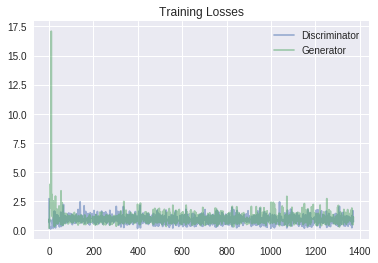

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

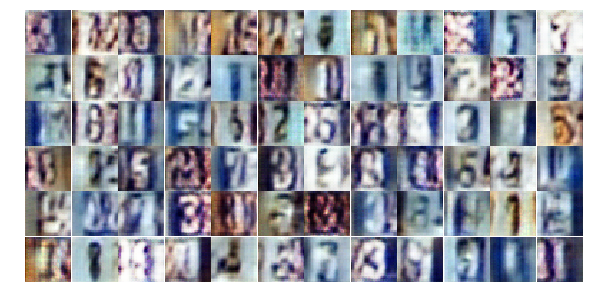

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))